<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>TRABAJO FIN DE MÁSTER</header1></center>

## Importación de librerias necesarias

In [4]:
from pandas import read_csv
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
import statsmodels.api as sm
import scipy.stats as stats

## Lectura del fichero

In [6]:
df = pd.read_csv("df_modelo_POST_EDA.csv")

df.head()

,FECHA,COD_MUNICIPIO,MUNICIPIO,POBLACION_TOTAL,PROP_ENVEJECIMIENTO,TASA_DEMANDA,TASA_PARO,SERVICIOS_TURISTICOS,SERVICIOS_SANIDAD,ESCUELAS,EMPRESAS,PROP_POBLACION_EXTRANJERA,DISTANCIA_CAPITAL
0,2012,42001,42001 ABEJAR,367,0.318801,13.004484,11.210762,27.0,2.0,0.0,18.0,0.073569,27.4
1,2012,42003,42003 ADRADAS,70,0.471429,10.810811,5.405405,4.0,2.0,0.0,6.0,0.000000,54.3
2,2012,42004,42004 AGREDA,3177,0.246774,12.740510,10.816433,5.0,1.0,3.0,189.0,0.107963,57.1
3,2012,42006,42006 ALCONABA,190,0.268421,7.692308,5.384615,0.0,3.0,0.0,6.0,0.100000,13.0
4,2012,42007,42007 ALCUBILLA DE AVELLANEDA,161,0.540373,8.219178,6.849315,2.0,4.0,0.0,4.0,0.093168,78.9


Se define la población municipal como variable dependiente del modelo, que será el objetivo a explicar en la fase explicativa del análisis.

Se eliminan del conjunto de variables explicativas la variable dependiente, los identificadores territoriales y la variable temporal, con el fin de evitar un enfoque de datos panel y tratar cada observación como independiente.

Se revisan los tipos de datos de las variables explicativas para verificar que todas ellas sean de naturaleza numérica y aptas para su uso en modelos de regresión.

In [8]:
#DEFINIMOS VARIABLE DEPENDIENTE
y = df["POBLACION_TOTAL"]

#DEFINIMOS VARIABLES INDEPENDIENTES
X = df.drop(columns=[
    "POBLACION_TOTAL",
    "FECHA",
    "MUNICIPIO",
    "COD_MUNICIPIO"
])

X.dtypes

PROP_ENVEJECIMIENTO          float64
TASA_DEMANDA                 float64
TASA_PARO                    float64
SERVICIOS_TURISTICOS         float64
SERVICIOS_SANIDAD            float64
ESCUELAS                     float64
EMPRESAS                     float64
PROP_POBLACION_EXTRANJERA    float64
DISTANCIA_CAPITAL            float64
dtype: object

In [9]:
X.isnull().sum().sort_values(ascending=False)

PROP_ENVEJECIMIENTO          0
TASA_DEMANDA                 0
TASA_PARO                    0
SERVICIOS_TURISTICOS         0
SERVICIOS_SANIDAD            0
ESCUELAS                     0
EMPRESAS                     0
PROP_POBLACION_EXTRANJERA    0
DISTANCIA_CAPITAL            0
dtype: int64

## Modelo LASSO

Las variables explicativas se estandarizan para garantizar que todas contribuyan de forma comparable al modelo LASSO, cuya penalización depende de la magnitud de los coeficientes..index
)

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)

Se ajusta un modelo de regresión LASSO utilizando validación cruzada para seleccionar automáticamente el parámetro de regularización óptimo, equilibrando complejidad y capacidad explicativa.

In [14]:
lasso = LassoCV(
    cv=5,
    random_state=42,
    max_iter=10000
)

lasso.fit(X_scaled, y)

LassoCV(cv=5, max_iter=10000, random_state=42)

Se obtiene el valor óptimo del parámetro de regularización que controla la intensidad de la penalización aplicada a los coeficientes del modelo.

In [16]:
lasso.alpha_

0.7350057725870647

El valor óptimo del parámetro de regularización obtenido mediante validación cruzada es α = 0.73, lo que indica una penalización moderada que permite seleccionar variables relevantes y reducir la complejidad del modelo

Se extraen y ordenan los coeficientes estimados por el modelo LASSO, identificando las variables con mayor contribución al modelo explicativo.

In [19]:
coef_lasso = pd.Series(
    lasso.coef_,
    index=X.columns
).sort_values(key=abs, ascending=False)

coef_lasso

EMPRESAS                     704.768967
SERVICIOS_TURISTICOS         -73.803805
ESCUELAS                      70.382814
SERVICIOS_SANIDAD             18.753186
PROP_POBLACION_EXTRANJERA     11.878588
TASA_DEMANDA                   9.412305
DISTANCIA_CAPITAL             -7.780552
PROP_ENVEJECIMIENTO            3.333029
TASA_PARO                      2.852628
dtype: float64

Se identifican las variables con coeficientes distintos de cero, consideradas relevantes para explicar la población municipal en la fase explicativa del análisis.

In [21]:
variables_seleccionadas = coef_lasso[coef_lasso != 0].index.tolist()

variables_seleccionadas

['EMPRESAS',
 'SERVICIOS_TURISTICOS',
 'ESCUELAS',
 'SERVICIOS_SANIDAD',
 'PROP_POBLACION_EXTRANJERA',
 'TASA_DEMANDA',
 'DISTANCIA_CAPITAL',
 'PROP_ENVEJECIMIENTO',
 'TASA_PARO']

El modelo LASSO no eliminó ninguna de las variables consideradas, lo que sugiere que todos los indicadores incluidos aportan información relevante para explicar la población municipal. Este resultado refuerza la coherencia del conjunto de variables seleccionadas a partir del marco teórico

## Modelo OLS

Se añade un término constante al modelo para capturar el valor medio de la población cuando el resto de variables explicativas toman valor cero.

In [25]:
X_ols = sm.add_constant(X)

Se ajusta un modelo de regresión lineal por mínimos cuadrados ordinarios para estimar el efecto de cada variable explicativa sobre la población municipal.

In [27]:
ols_model = sm.OLS(y, X_ols)
ols_results = ols_model.fit()

Se muestra el resumen completo del modelo OLS, que incluye coeficientes estimados, errores estándar, p-values y medidas globales de ajuste.

In [29]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        POBLACION_TOTAL   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.490e+04
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:06:34   Log-Likelihood:                -14198.
No. Observations:                2366   AIC:                         2.842e+04
Df Residuals:                    2356   BIC:                         2.847e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        29.3903      9.408      3.124      0.002      10.941      47.840
PROP_ENVEJECIMIENTO          39.6920     19.560      2.029      0.043       1.335      78.049
TASA_DEMANDA                  1.6515      0.695      2.376      0.018       0.288       3.014
TASA_PARO                     0.6666      0.898      0.742      0.458      -1.095       2.428
SERVICIOS_TURISTICOS        -11.1410      0.451    -24.720      0.000     -12.025     -10.257
SERVICIOS_SANIDAD             8.4564      1.067      7.922      0.000       6.363      10.550
ESCUELAS                     71.5550      6.080     11.770      0.000      59.633      83.477
EMPRESAS                     15.0480      0.136    110.949      0.000      14.782      15.314
PROP_POBLACION_EXTRANJERA   231.5719     40.842      5.670      0.000     151.481     311.663
DISTANCIA_CAPITAL            -0.4710      0.108     -4.360      0.000      -0.683      -0.259
==============================================================================
Omnibus:                      851.499   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23002.726
Skew:                           1.107   Prob(JB):                         0.00
Kurtosis:                      18.114   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Como hay algunas variables no significativas, vamos a hacer una seleccion de modelos

In [31]:
import statsmodels.api as sm

def backward_selection_aic(X, y):
    X = sm.add_constant(X)
    variables = list(X.columns)

    while True:
        model = sm.OLS(y, X[variables]).fit()
        aic_actual = model.aic

        aic_vars = []
        for var in variables:
            if var == "const":
                continue
            vars_temp = [v for v in variables if v != var]
            model_temp = sm.OLS(y, X[vars_temp]).fit()
            aic_vars.append((model_temp.aic, var))

        mejor_aic, peor_var = min(aic_vars)

        if mejor_aic < aic_actual:
            variables.remove(peor_var)
        else:
            break

    return variables

In [32]:
variables_finales = backward_selection_aic(X, y)
variables_finales

['const',
 'PROP_ENVEJECIMIENTO',
 'TASA_DEMANDA',
 'SERVICIOS_TURISTICOS',
 'SERVICIOS_SANIDAD',
 'ESCUELAS',
 'EMPRESAS',
 'PROP_POBLACION_EXTRANJERA',
 'DISTANCIA_CAPITAL']

In [33]:
variables_finales.remove("const")
X_final = sm.add_constant(X[variables_finales])
modelo_final = sm.OLS(y, X_final).fit(cov_type="HC3")
modelo_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        POBLACION_TOTAL   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1712.
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        19:06:35   Log-Likelihood:                -14198.
No. Observations:                2366   AIC:                         2.841e+04
Df Residuals:                    2357   BIC:                         2.847e+04
Df Model:                           8                                         
Covariance Type:                  HC3                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        29.4588      9.071      3.248      0.001      11.680      47.238
PROP_ENVEJECIMIENTO          39.8844     14.258      2.797      0.005      11.938      67.830
TASA_DEMANDA                  2.0987      0.315      6.655      0.000       1.481       2.717
SERVICIOS_TURISTICOS        -11.1485      0.988    -11.287      0.000     -13.084      -9.213
SERVICIOS_SANIDAD             8.4600      1.882      4.494      0.000       4.771      12.149
ESCUELAS                     71.6619     14.206      5.045      0.000      43.819      99.505
EMPRESAS                     15.0463      0.357     42.110      0.000      14.346      15.747
PROP_POBLACION_EXTRANJERA   231.6604     50.557      4.582      0.000     132.571     330.750
DISTANCIA_CAPITAL            -0.4685      0.105     -4.478      0.000      -0.674      -0.263
==============================================================================
Omnibus:                      854.676   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23068.921
Skew:                           1.113   Prob(JB):                         0.00
Kurtosis:                      18.134   Cond. No.                     1.21e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Validamos normalidad, multicolinealidad, homocedasticidad y correlaciones. 

In [35]:
#Se extraen los residuos del modelo OLS para evaluar sus propiedades estadísticas.
residuos = modelo_final.resid

Validamos NORMALIDAD:

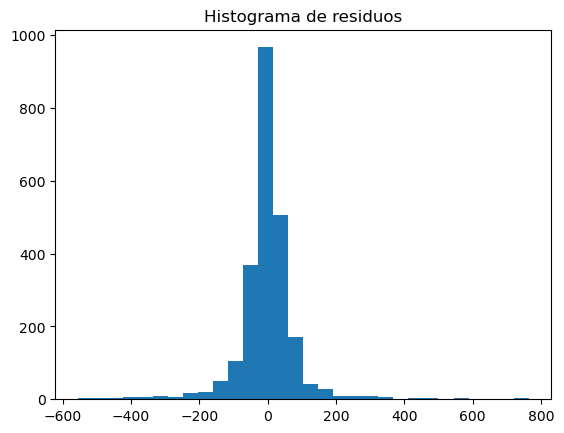

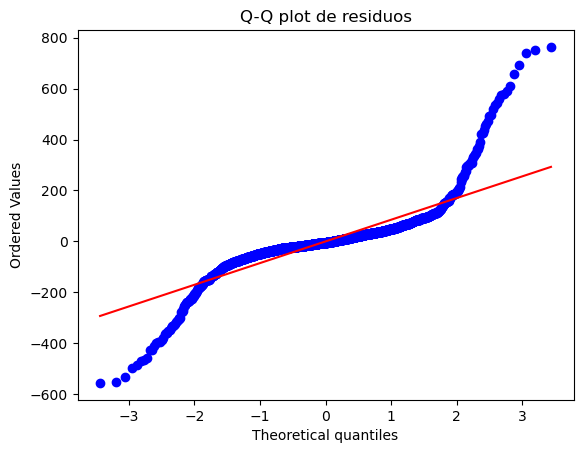

In [37]:
# Histograma
plt.hist(residuos, bins=30)
plt.title("Histograma de residuos")
plt.show()

# Q-Q plot
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Q-Q plot de residuos")
plt.show()

In [38]:
#SE USA JARQUE - BERA YA QUE SHAPIRO WILK PARA MUESTRAS GRANDES CASI SIEMPRE SE RECHAZA

from statsmodels.stats.stattools import jarque_bera

jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuos)

jb_results = {
    "JB statistic": jb_stat,
    "JB p-value": jb_pvalue,
    "Skewness": skew,
    "Kurtosis": kurtosis
}

jb_results

{'JB statistic': 23068.920630754623,
 'JB p-value': 0.0,
 'Skewness': 1.1134997088966891,
 'Kurtosis': 18.134224140879002}

Validamos LINEALIDAD: Verificar que la relación entre variables explicativas y la variable dependiente es aproximadamente lineal.

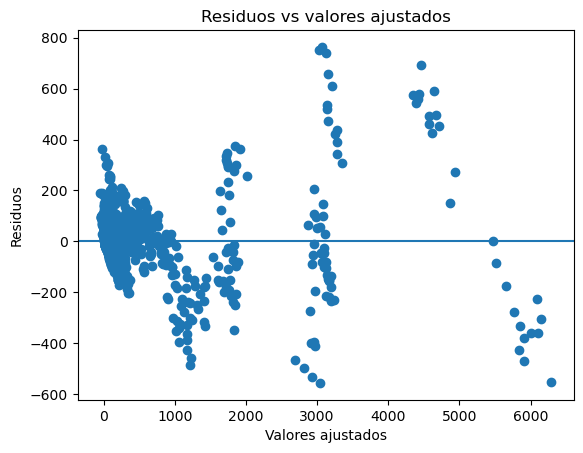

In [40]:
valores_ajustados = modelo_final.fittedvalues

plt.scatter(valores_ajustados, residuos)
plt.axhline(0)
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs valores ajustados")
plt.show()

In [41]:
#TEST RESET DE RAMSEY
from statsmodels.stats.diagnostic import linear_reset

reset_test = linear_reset(
    modelo_final,
    power=2,
    use_f=True
)

reset_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.0040709189910427815, p=0.9491319019296044, df_denom=2.36e+03, df_num=1>

El test RESET de Ramsey no rechaza la hipótesis nula de correcta especificación funcional, lo que sugiere que el modelo lineal es adecuado

Validamos heterocedasticidad: Comprobar si la varianza de los residuos es constante.
test de breusch pagan

In [44]:
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuos, X_final)

bp_results = pd.Series(
    bp_test,
    index=["LM Statistic", "LM p-value", "F Statistic", "F p-value"]
)

bp_results

LM Statistic     1.052260e+03
LM p-value      7.802006e-222
F Statistic      2.359845e+02
F p-value       1.864897e-294
dtype: float64

VALIDAMOS CORRELACION: DURBIN WATSON

In [46]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuos)

dw_stat

1.9923217041405714

Validamos MULTICOLINEALIDAD: VIF

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_ols.copy()

vif = pd.DataFrame()
vif["Variable"] = X_vif.columns
vif["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif

,Variable,VIF
0,const,21.848717
1,PROP_ENVEJECIMIENTO,1.506310
2,TASA_DEMANDA,4.737453
3,TASA_PARO,4.530568
4,SERVICIOS_TURISTICOS,2.393651
5,SERVICIOS_SANIDAD,1.585825
6,ESCUELAS,9.023335
7,EMPRESAS,10.002651
8,PROP_POBLACION_EXTRANJERA,1.295159
9,DISTANCIA_CAPITAL,1.159902


## DIAGNOSTICO DE CASOS INFLUYENTES

In [50]:
influence = ols_results.get_influence()

In [51]:
leverage = influence.hat_matrix_diag

In [52]:
n = X_final.shape[0]
k = X_final.shape[1] - 1  # sin constante

umbral_leverage = 2 * (k + 1) / n
umbral_leverage

0.0076077768385460695

In [53]:
obs_leverage_alto = leverage > umbral_leverage
sum(obs_leverage_alto)

280

In [54]:
id_cols = ["COD_MUNICIPIO", "MUNICIPIO", "FECHA"]
df_ids = df[id_cols].copy()

In [55]:
df_ids["leverage"] = leverage

obs_influyentes = df_ids[df_ids["leverage"] > umbral_leverage]
obs_influyentes.sort_values("leverage", ascending=False).head(20)

,COD_MUNICIPIO,MUNICIPIO,FECHA,leverage
1456,42001,42001 ABEJAR,2020,0.323982
381,42020,42020 ALMAZAN,2014,0.040599
745,42020,42020 ALMAZAN,2016,0.039374
563,42020,42020 ALMAZAN,2015,0.035921
199,42020,42020 ALMAZAN,2013,0.033968
17,42020,42020 ALMAZAN,2012,0.033520
1837,42020,42020 ALMAZAN,2022,0.032644
2201,42020,42020 ALMAZAN,2024,0.032344
2019,42020,42020 ALMAZAN,2023,0.032267
1868,42053,42053 CARRASCOSA DE ABAJO,2022,0.032087


In [56]:
obs_influyentes.sort_values("leverage", ascending=False)

cooks_d = influence.cooks_distance[0]

n = X_final.shape[0]
umbral_cook = 4 / n
umbral_cook

df_cook = df.copy()
df_cook["cooks_distance"] = cooks_d

obs_cook_influyentes = df_cook[df_cook["cooks_distance"] > umbral_cook]
obs_cook_influyentes.shape[0]

obs_cook_influyentes[[
    "COD_MUNICIPIO",
    "MUNICIPIO",
    "FECHA",
    "cooks_distance"
]].sort_values("cooks_distance", ascending=False).head(20)

,COD_MUNICIPIO,MUNICIPIO,FECHA,cooks_distance
563,42020,42020 ALMAZAN,2015,0.123359
949,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2017,0.091922
1131,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2018,0.090530
403,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2014,0.086731
1313,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2019,0.083826
1837,42020,42020 ALMAZAN,2022,0.079515
2297,42134,42134 OLVEGA,2024,0.077996
39,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2012,0.077179
113,42134,42134 OLVEGA,2012,0.075423
1495,42043,42043 BURGO DE OSMA-CIUDAD DE OSMA,2020,0.072117


In [180]:
obs_cook_influyentes[[
    "COD_MUNICIPIO",
    "MUNICIPIO",
    "FECHA",
    "cooks_distance"
]].to_csv(
    "obs_influyentes.csv",
    index=False,
    encoding="utf-8"
)